In [1]:
import numpy as np
import pandas as pd
from scipy.linalg import expm
from scipy.stats import truncexpon
from scipy.stats import expon
import scipy.special
import ast
%load_ext rpy2.ipython

In [2]:
def combine_states(iter_lst_a, iter_lst_b, probs_a, probs_b):
    """
    Given two lists of states and their probabilities, this
    function returns a list of combined states and their
    probabilities. 
    
    Each state is represented by a list of tuples. Each
    tuple of size 2 corresponds to two consecutive sites, so
    left and right respectively. 0 corresponds to no site, 1
    to an uncoalesced site, 2 to a site with one coalescent 
    from 2 sites, 3 to 2 coalescents from 3 sites, and so on.
    For example, (0, 1) corresponds to (  -o), while (1, 2)
    represents (o--x). A list of tuples, thus, represents a 
    state of a CTMC.
    
    Parameters
    ----------
    iter_lst_a : list of lists of tuples
        Each nested list represents the CTMC states
    iter_lst_b : list of lists of tuples
        Each nested list represents the CTMC states
    probs_a : list
        Probabilities corresponding to iter_lst_a
    probs_a : list
        Probabilities corresponding to iter_lst_b
    """
    iter_lst_ab = []
    probs_ab = []
    for i in range(len(iter_lst_a)):
        for j in range(len(iter_lst_b)):
            iter_lst_ab.append(sorted(iter_lst_a[i]+iter_lst_b[j]))
            probs_ab.append(probs_a[i]*probs_b[j])
    # Define new data frame
    df = pd.DataFrame()
    # Save names of state
    df['name'] = [str(i) for i in iter_lst_ab]
    # Save probabilities
    df['value'] = probs_ab
    # Group by state and sum probabilities
    df = df.groupby("name", as_index=False).sum()
    return list(df['name']), list(df['value'])

In [3]:
def load_trans_mat(n_seq):
    """
    This functions returns a string matrix for the CTMC.
    
    Parameters
    ----------
    n_seq : integer
        Number of sequences of the CTMC
    """
    
    # Read string data frame for the CTMC
    df = pd.read_csv('../02_state_space/trans_mats/trans_mat_simple_'+str(n_seq)+'.csv')
    
    # Create dictionary with all CTMC state names and their index
    df_2 = {
        'names': pd.concat([df['from_str'], df['to_str']]),
        'values': pd.concat([df['from'], df['to']])
    }
    # Convert names to data frame, drop duplicated states and sort by index
    df_2 = pd.DataFrame(data=df_2).drop_duplicates().sort_values(by=['values'])
    
    # Pivot data frame to matrix, and fill missing values with '0'
    df_1 = df[['value', 'from', 'to']].pivot(index='from',columns='to',values='value').fillna('0')
    # Reset column names
    df_1.columns.name = None
    df_1 = df_1.reset_index().iloc[:, 1:]
    
    return np.array(df_1), list(df_2['names'])

In [4]:
def trans_mat_num(trans_mat, coal, rho):
    """
    This function returns a transition matrix given a 
    string matrix whose values are either '0', or 'R'
    or 'C' preceeded by a number, corresponding to a
    multiplication factor for the recombination and 
    the coalescence rate, respectively. The user can
    specify these two numerical rates. The function
    calculates the rates in the diagonals as  
    (-1)*rowSums
    
    Parameters
    ----------
    trans_mat : string numpy matrix
        Matrix containing coalescent and recombination
        rates in strings.
    coal : float
        Coalescent rate.
    rho : float
        Recombination rate
    """
    # Define the number of rows and columns from string matrix shape
    num_rows, num_cols = trans_mat.shape
    # Define numeric matrix of that shape
    trans_mat_num = np.full((num_rows, num_cols), 0.0)
    # For each row
    for i in range(num_rows):
        # For each column
        for j in range(num_cols):
            # If the string matrix is '0'
            if trans_mat[i,j] == '0':
                # Add numeric 0 to numeric matrix
                trans_mat_num[i,j] = 0.0
            # Otherwise
            else:
                # Multiply factor from string matrix to either coalescent or recombination rate
                trans_mat_num[i,j] = int(trans_mat[i,j][:-1])*(coal if trans_mat[i,j][-1]=='C' else rho)
    # Calculate diagonal as (-1)*rowSums
    for i in range(num_rows):
        trans_mat_num[i,i]=-sum(trans_mat_num[i])
    return trans_mat_num

In [5]:
def cutpoints_AB(n_int_AB, t_AB, coal_AB):
    """
    This function returns a the cutpoints for the
    intervals for the two-sequence CTMC. The cutpoints
    will be defined by the quantiles of a truncated
    exponential distribution. 
    
    Parameters
    ----------
    n_int_AB : integer
        Number of intervals in the two-sequence CTMC.
    t_AB : float
        Total time interval of the two-sequence CTMC
    coal_AB : float
        coalescent rate of the two-sequence CTMC.
    """
    # Define probabilities for quantiles
    quantiles_AB = np.array(list(range(n_int_AB+1)))/n_int_AB
    # Define truncexpon shape parameters
    lower, upper, scale = 0, t_AB, 1/coal_AB
    # Get quantiles
    cut_AB = truncexpon.ppf(quantiles_AB, b=(upper-lower)/scale, loc=lower, scale=scale)
    return cut_AB 

In [6]:
def cutpoints_ABC(n_int_ABC, coal_ABC):
    """
    This function returns a the cutpoints for the
    intervals for the three-sequence CTMC. The cutpoints
    will be defined by the quantiles of an exponential 
    distribution. 
    
    Parameters
    ----------
    n_int_ABC : integer
        Number of intervals in the three-sequence CTMC.
    coal_ABC : float
        coalescent rate of the three-sequence CTMC.
    """
    # Define probabilities for quantiles
    quantiles_AB = np.array(list(range(n_int_ABC+1)))/n_int_ABC
    # Get quantiles
    cut_ABC = expon.ppf(quantiles_AB, scale=1/coal_ABC)
    return cut_ABC

In [7]:
def get_ABC(trans_mat, times, omegas):
    """
    This function calculates the joint probabilities
    for the two-sequence CTMC.
    
    Parameters
    ----------
    trans_mat : numpy array
        The transition rate matrix of the two-sequence CTMC
    times : list of numbers
        Time intervals for each matrix multiplication
    omegas : list of lists
        Sets of states for each matrix multiplication
    """
    # Calculate first multiplication
    g = expm(trans_mat*times[0])[omegas[0]][:,omegas[1]]
    # For each of the remaining omegas
    for i in range(1, len(times)):
        # Perform multiplication
        g = g @ expm(trans_mat*times[i])[omegas[i]][:,omegas[i+1]]
    # Return a numpy array that contains the probabilities in the right order.
    return g

In [8]:
def get_ABC_inf_bis(trans_mat, times, omegas):
    """
    This function calculates the joint probabilities
    for the three-sequence CTMC. It is a wrapper function
    of get_ABC(), which outputs the same as get_ABC() if the
    last interval does not end in infinity. If instead the last
    interval contains infinity, then get_ABC() is run without
    the last interval. This is a trick because expm cannot 
    handle infinite values. However, the sum of the output will
    not change, because once we have reached the last interval,
    the coalescent within that time interval will equal to 1.
    
    Parameters
    ----------
    trans_mat : numpy array
        The transition rate matrix of the two-sequence CTMC
    times : list of numbers
        Time intervals for each matrix multiplication
    omegas : list of lists
        Sets of states for each matrix multiplication
    """
    if times[-1] == np.inf:
        g = get_ABC(trans_mat, times[:-1], omegas[:-1])
    else:
        g = get_ABC(trans_mat, times, omegas)
    return g

In [9]:
def get_ordered(p_ABC, omega_end, omega_tot):
    """
    This functions orders a list of probabilities given
    a list of its indices and a list with all possible
    indices. 
    
    Parameters
    ----------
    p_ABC : list of floats
        Probabilities to be ordered
    omega_end : list of integers
        Indices of the probabilities
    omega_tot : list of integers
        List of all possible indices
    """
    # Add probability to list if its index equals the position in
    #  omega_tot, otherwise add 0
    return np.array([p_ABC[omega_end.index(j)] if j in omega_end else 0 for j in omega_tot])

In [10]:
def get_times(cut, intervals):
    """
    This functions returns a list of times representing
    the time within each of the specified intervals. It 
    does so by using a list of all possible cutpoints and
    a list of indices representing the interval cutpoints
    in order.
    
    Parameters
    ----------
    cut : list of floats
        List of ordered cutpoints
    intervals : list of integers
        Ordered indices of cutpoints
    """
    return [cut[intervals[i+1]]-cut[intervals[i]] for i in range(len(intervals)-1)]

In [11]:
def get_tab_AB(state_space_AB, trans_mat_AB, cut_AB, pi_AB):
    """
    This functions returns a table with joint probabilities of
    the end probabilities per state after running a two-sequence
    CTMC segregated by the fate of each pair of sites. 
    
    Parameters
    ----------
    state_space_AB : list of lists of tuples
        States of the whole state space two-sequence CTMC
    trans_mat_AB : numeric numpy matrix
        Transition rate matrix of the two-sequence CTMC
    cut_AB : list of floats
        Ordered cutpoints of the two-sequence CTMC
    pi_AB : list of floats
        Starting probabilities after merging two one-sequence CTMCs. 
    """
    
    ###############################
    ### State-space information ###
    ###############################
    
    # Get flatten list of states, where even-indexed numbers (0, 2, ...)
    # represent the left-side coalescence states and odd-indexed numbers
    # (1, 3, ...) represent right-side coalescence.
    flatten = [list(sum(i, ())) for i in state_space_AB]
    # Get the index of all states where there is not a 2 (no coalescent)
    omega_B = [i for i in range(9) if 2 not in flatten[i]]
    # Get the index of all states where there is a 2 on left but not on right
    omega_L = [i for i in range(9) if (2 in flatten[i][::2]) and (2 not in flatten[i][1::2])]
    # Get the index of all states where there is a 2 on right but not on left
    omega_R = [i for i in range(9) if (2 not in flatten[i][::2]) and (2 in flatten[i][1::2])]
    # Get the index of all states where there is a 2 on left and right
    omega_E = [i for i in range(9) if (2 in flatten[i][::2]) and (2 in flatten[i][1::2])]
    # Get the index of all states
    omega_tot_AB = [i for i in range(9)]
    
    # Number of intervals
    n_int_AB = len(cut_AB)-1
    # Create empty table for the joint probabilities
    tab = np.zeros((n_int_AB*n_int_AB+n_int_AB*2+1, 9))
    # Create empty vector for the names of the states
    tab_names = []
    # Create accumulator for keeping track of the indices for the table
    acc = 0
    
    ############################################
    ### Deep coalescence -> deep coalescence ###
    ############################################
    
    # A pair of sites whose fate is to be of deep coalescence is represented as (('D'), ('D')).
    p_ABC = pi_AB @ get_ABC(trans_mat_AB, [cut_AB[-1]-cut_AB[0]], [omega_tot_AB, omega_B])
    tab[acc] = get_ordered(p_ABC, omega_B, omega_tot_AB)
    tab_names.append((('D'), ('D')))
    acc += 1
    
    ##############################
    ### V0 -> deep coalescence ###
    ### Deep coalescence -> V0 ###
    ##############################
    
    # A pair of sites where the left site is in V0 and the right site is of deep coalescence
    # is represented as ((0, L), ('D')), where L is the index of the interval where the first
    # left coalescent happens. Remember that the probability of ((0, L) -> ('D')) is the same as
    # that of (('D'), (0, L)).
    for L in range(n_int_AB):
        times = get_times(cut_AB, [0, L, L+1, -1])
        omegas = [omega_tot_AB, omega_B, omega_L, omega_L]
        p_ABC = pi_AB @ get_ABC(trans_mat_AB, times, omegas)
        p_ABC = get_ordered(p_ABC, omega_L, omega_tot_AB)
        tab[acc] = p_ABC
        tab_names.append(((0, L), ('D')))
        tab[acc+1] = p_ABC
        tab_names.append((('D'), (0, L)))
        acc += 2
        
    ################
    ### V0 -> V0 ###
    ################    
    
    # A pair of sites whose fate is to be V0 states is represented as ((0, L), (0, R)), where
    # L is the index of the interval where the first left coalescent happens, and R is the same
    # for the first right coalescent. Remember that the probability of ((0, L) -> (0, R)) equals
    # that of ((0, R), (0, L)).
    for L in range(n_int_AB):
        for R in range(L, n_int_AB):
            if R == L:
                times = get_times(cut_AB, [0, L, L+1, -1])
                omegas = [omega_tot_AB, omega_B, omega_E, omega_E]
                p_ABC = pi_AB @ get_ABC(trans_mat_AB, times, omegas)
                tab[acc] = get_ordered(p_ABC, omega_E, omega_tot_AB)
                tab_names.append(((0, L), (0, R)))
                acc += 1
            elif L < R:
                times = get_times(cut_AB, [0, L, L+1, R, R+1, -1])
                omegas = [omega_tot_AB, omega_B, omega_L, omega_L, omega_E, omega_E]
                p_ABC = pi_AB @ get_ABC(trans_mat_AB, times, omegas)
                p_ABC = get_ordered(p_ABC, omega_E, omega_tot_AB)
                tab[acc] = p_ABC
                tab_names.append(((0, L), (0, R)))
                tab[acc+1] = p_ABC
                tab_names.append(((0, R), (0, L)))
                acc += 2
            
    return tab_names, tab

In [12]:
def get_tab_ABC(state_space_ABC, trans_mat_ABC, cut_ABC, pi_ABC, names_tab_AB, n_int_AB):
    """
    This functions returns a table with joint probabilities of
    the states of the HMM after running a three-sequence CTMC
    
    Parameters
    ----------
    state_space_ABC : list of lists of tuples
        States of the whole state space of the three-sequence CTMC
    trans_mat_ABC : numeric numpy matrix
        Transition rate matrix of the three-sequence CTMC
    cut_ABC : list of floats
        Ordered cutpoints of the three-sequence CTMC
    pi_ABC : list of floats
        Starting probabilities after merging a one-sequence and a
        two-sequence CTMCs. 
    names_tab_AB : list of tuples
        List of fates for the starting probabilities, as outputted
        by get_tab_AB().
    n_int_AB : integer
        Number of intervals in the two-sequence CTMC
    """
    
    ###############################
    ### State-space information ###
    ###############################
    
    # Get flatten list of states, where even-indexed numbers (0, 2, ...)
    # represent the left-side coalescence states and odd-indexed numbers
    # (1, 3, ...) represent right-side coalescence.
    flatten = [list(sum(i, ())) for i in state_space_ABC]
    # Get the index of all states
    omega_tot_ABC = [i for i in range(31)]
    # Get the index of all states where there is not a 2 or a 3 (no coalescent)
    omega_00 = [i for i in range(31) if all(x not in [2, 3] for x in flatten[i])]
    # Get the index of all states where there is a 2 on left but not on right (one coalescent on left)
    omega_10 = [i for i in range(31) if (2 in flatten[i][::2]) and (all(x not in [2, 3] for x in flatten[i][1::2]))]
    # Get the index of all states where there is a 2 on right but not on left (one coalescent on right)
    omega_01 = [i for i in range(31) if (all(x not in [2, 3] for x in flatten[i][::2])) and (2 in flatten[i][1::2])]
    # Get the index of all states where there is a 2 on left and on right (one coalescent on left and right)
    omega_11 = [i for i in range(31) if (2 in flatten[i][::2]) and (2 in flatten[i][1::2])]
    # Get the index of all states where there is a 2 on left and a 3 on right (one coalescent on left, two on right)
    omega_12 = [i for i in range(31) if (2 in flatten[i][::2]) and (3 in flatten[i][1::2])]
    # Get the index of all states where there is a 2 on right and a 3 on left (one coalescent on right, two on left)
    omega_21 = [i for i in range(31) if (3 in flatten[i][::2]) and (2 in flatten[i][1::2])]
    # Get the index of all states where there is a 3 on left and on right (two coalescents on left and right)
    omega_22 = [i for i in range(31) if (3 in flatten[i][::2]) and (3 in flatten[i][1::2])]
    # Get the index of all states where there is a 3 on left, and no 2 or 3 on right (two coalescents on left, none on right)
    omega_20 = [i for i in range(31) if (3 in flatten[i][::2]) and (all(x not in [2, 3] for x in flatten[i][1::2]))]
    # Get the index of all states where there is a 3 on right, and no 2 or 3 on left (two coalescents on right, none on right)
    omega_02 = [i for i in range(31) if (all(x not in [2, 3] for x in flatten[i][::2])) and (3 in flatten[i][1::2])]
    
    # Number of final states
    n_int_ABC = len(cut_ABC)-1
    n_markov_states = n_int_AB*n_int_ABC+n_int_ABC+3*scipy.special.comb(n_int_ABC, 2, exact = True)
    
    # Create empty transition probability matrix
    tab=np.empty((n_markov_states**2, 3), dtype=object)
    # Create accumulator for keeping track of the indices for the table
    acc_tot = 0
    
    ################
    ### V0 -> V0 ###
    ################
    
    # A pair of sites whose fate is to be V0 states is represented as ((0, l, L), (0, r, R)), where
    # l is the index of the interval where the first left coalescent happens, r is the same
    # for the first right coalescent, L is the same for the second left coalescent, and R is the 
    # second right coalescent. Remember that the probability of ((0, l, L) -> (0, r, R)) equals
    # that of ((0, r, R), (0, l, L)).
    for l in range(n_int_AB):
        for r in range(n_int_AB):
            cond = [i == ((0, l),(0, r)) for i in names_tab_AB]
            pi = pi_ABC[cond]
            for L in range(n_int_ABC):
                for R in range(n_int_ABC):
                    if L < R:                        
                        times_ABC = get_times(cut_ABC, [0, L, L+1, R, R+1])
                        omegas_ABC = [omega_tot_ABC, omega_11, omega_21, omega_21, omega_22]
                        p_ABC = get_ABC_inf_bis(trans_mat_ABC, times_ABC, omegas_ABC)
                        tab[acc_tot]   = [(0, l, L), (0, r, R), (pi@p_ABC).sum()]
                        tab[acc_tot+1] = [(0, r, R), (0, l, L), (pi@p_ABC).sum()]
                        acc_tot += 2
                    elif L == R:
                        times_ABC = get_times(cut_ABC, [0, L, L+1])
                        omegas_ABC = [omega_tot_ABC, omega_11, omega_22]
                        p_ABC = get_ABC_inf_bis(trans_mat_ABC, times_ABC, omegas_ABC)
                        tab[acc_tot] = [(0, l, L), (0, r, R), (pi@p_ABC).sum()]
                        acc_tot += 1
                    else:
                        continue
  
    ##############################
    ### V0 -> deep coalescence ###
    ### Deep coalescence -> V0 ###
    ##############################
    
    # A pair of sites where the left site is in V0 and the right site is of deep coalescence
    # is represented as ((0, l, L), (i, r, R)), where l is the index of the interval where the 
    # first left coalescent happens, L is the same for the second left coalescent, r is the 
    # same for the first right coalescent and R is the same for the second right coalescent. The index
    # i can take values from 1 to 4, where 1 to 3 represents deep coalescent and l < L, and 4 
    # represents a multiple merger event where l = L. Remember that the probability of 
    # ((0, l, L) -> (i, r, R)) and that of ((i, r, R) -> (0, l, L)) is the same. Also,
    # ((0, l, L) -> (1, r, R)) = ((0, l, L) -> (2, r, R)) = ((0, l, L) -> (3, r, R)), following ILS.
    for l in range(n_int_AB):
        cond = [i == ((0, l), 'D') for i in names_tab_AB]
        pi = pi_ABC[cond]
        for L in range(n_int_ABC):
            for r in range(n_int_ABC):
                for R in range(r, n_int_ABC):
                    if L < r < R:
                        times_ABC = get_times(cut_ABC, [0, L, L+1, r, r+1, R, R+1])
                        omegas_ABC = [omega_tot_ABC, omega_10, omega_20, omega_20, omega_21, omega_21, omega_22]
                    elif L == r < R:
                        times_ABC = get_times(cut_ABC, [0, L, L+1, R, R+1])
                        omegas_ABC = [omega_tot_ABC, omega_10, omega_21, omega_21, omega_22]
                    elif r < L < R:
                        times_ABC = get_times(cut_ABC, [0, r, r+1, L, L+1, R, R+1])
                        omegas_ABC = [omega_tot_ABC, omega_10, omega_11, omega_11, omega_21, omega_21, omega_22]
                    elif r < L == R:
                        times_ABC = get_times(cut_ABC, [0, r, r+1, L, L+1])
                        omegas_ABC = [omega_tot_ABC, omega_10, omega_11, omega_11, omega_22]
                    elif r < R < L:
                        times_ABC = get_times(cut_ABC, [0, r, r+1, R, R+1, L, L+1])
                        omegas_ABC = [omega_tot_ABC, omega_10, omega_11, omega_11, omega_12, omega_12, omega_22]
                    elif L < r == R:
                        times_ABC = get_times(cut_ABC, [0, L, L+1, r, r+1])
                        omegas_ABC = [omega_tot_ABC, omega_10, omega_20, omega_20, omega_22]
                    elif L == r == R:
                        times_ABC = get_times(cut_ABC, [0, L, L+1])
                        omegas_ABC = [omega_tot_ABC, omega_10, omega_22]
                    elif r == R < L:
                        times_ABC = get_times(cut_ABC, [0, r, r+1, L, L+1])
                        omegas_ABC = [omega_tot_ABC, omega_10, omega_12, omega_12, omega_22]
                    else:
                        continue

                    p_ABC = get_ABC_inf_bis(trans_mat_ABC, times_ABC, omegas_ABC)
                    
                    if r < R:
                        tab[acc_tot:(acc_tot+3)]     = [[(0, l, L), (i, r, R), (pi@p_ABC).sum()/3] for i in range(1, 4)]
                        tab[(acc_tot+3):(acc_tot+6)] = [[(i, r, R), (0, l, L), (pi@p_ABC).sum()/3] for i in range(1, 4)]
                        acc_tot += 6
                    elif r == R:
                        tab[acc_tot]   = [(0, l, L), (4, r, R), (pi@p_ABC).sum()]
                        tab[acc_tot+1] = [(4, r, R), (0, l, L), (pi@p_ABC).sum()]
                        acc_tot += 2
      
    ############################################
    ### Deep coalescence -> deep coalescence ###
    ############################################
    
    # A pair of sites where both the left and the right site are of deep coalescence is 
    # represented as ((i, l, L), (j, r, R)), where l is the index of the interval where the 
    # first left coalescent happens, L is the same for the second left coalescent, r is the 
    # same for the first right coalescent and R is the same for the second right coalescent.
    # The indices i and j can take values from 1 to 4, where 1 to 3 represents deep coalescent 
    # and l < L, and 4  represents a multiple merger event where l = L. Remember that the probability 
    # of ((i, l, L) -> (j, r, R)) and that of ((j, r, R) -> (i, l, L)) is the same. Also,
    # ((i, l, L) -> (1, r, R)) = ((i, l, L) -> (2, r, R)) = ((i, l, L) -> (3, r, R)), following ILS.
    cond = [i == ('D','D') for i in names_tab_AB]
    pi = pi_ABC[cond]
    for l in range(n_int_ABC):
        for L in range(l, n_int_ABC):
            for r in range(n_int_ABC):
                for R in range(r, n_int_ABC): 
                    if l < L < r < R:
                        times_ABC = get_times(cut_ABC, [0, l, l+1, L, L+1, r, r+1, R, R+1])
                        omegas_ABC = [omega_tot_ABC, omega_00, omega_10, omega_10, omega_20, omega_20, omega_21, omega_21, omega_22]
                    elif l < L == r < R:
                        times_ABC = get_times(cut_ABC, [0, l, l+1, L, L+1, R, R+1])
                        omegas_ABC = [omega_tot_ABC, omega_00, omega_10, omega_10, omega_21, omega_21, omega_22]
                    elif l == r < L < R:
                        times_ABC = get_times(cut_ABC, [0, l, l+1, L, L+1, R, R+1])
                        omegas_ABC = [omega_tot_ABC, omega_00, omega_11, omega_11, omega_21, omega_21, omega_22]
                    elif l < r < L < R:
                        times_ABC = get_times(cut_ABC, [0, l, l+1, r, r+1, L, L+1, R, R+1])
                        omegas_ABC = [omega_tot_ABC, omega_00, omega_10, omega_10, omega_11, omega_11, omega_21, omega_21, omega_22]
                    elif r < l < L < R:
                        times_ABC = get_times(cut_ABC, [0, r, r+1, l, l+1, L, L+1, R, R+1])
                        omegas_ABC = [omega_tot_ABC, omega_00, omega_01, omega_01, omega_11, omega_11, omega_21, omega_21, omega_22]
                    elif l == r < L == R:
                        times_ABC = get_times(cut_ABC, [0, l, l+1, L, L+1])
                        omegas_ABC = [omega_tot_ABC, omega_00, omega_11, omega_11, omega_22]
                    elif l < r < L == R:
                        times_ABC = get_times(cut_ABC, [0, l, l+1, r, r+1, L, L+1])
                        omegas_ABC = [omega_tot_ABC, omega_00, omega_10, omega_10, omega_11, omega_11, omega_22]
                    elif l == r == L == R:
                        times_ABC = get_times(cut_ABC, [0, l, l+1])
                        omegas_ABC = [omega_tot_ABC, omega_00, omega_22]
                    elif l == L < r == R:
                        times_ABC = get_times(cut_ABC, [0, l, l+1, r, r+1])
                        omegas_ABC = [omega_tot_ABC, omega_00, omega_20, omega_20, omega_22]
                    elif l == L < r < R:
                        times_ABC = get_times(cut_ABC, [0, l, l+1, r, r+1, R, R+1])
                        omegas_ABC = [omega_tot_ABC, omega_00, omega_20, omega_20, omega_21, omega_21, omega_22]
                    elif l == L == r < R:
                        times_ABC = get_times(cut_ABC, [0, l, l+1, R, R+1])
                        omegas_ABC = [omega_tot_ABC, omega_00, omega_21, omega_21, omega_22]
                    elif l < L == r == R:
                        times_ABC = get_times(cut_ABC, [0, l, l+1, L, L+1])
                        omegas_ABC = [omega_tot_ABC, omega_00, omega_10, omega_10, omega_22]
                    elif l < L < r == R:
                        times_ABC = get_times(cut_ABC, [0, l, l+1, L, L+1, r, r+1])
                        omegas_ABC = [omega_tot_ABC, omega_00, omega_10, omega_10, omega_20, omega_20, omega_22]
                    elif r < l == L < R:
                        times_ABC = get_times(cut_ABC, [0, r, r+1, l, l+1, R, R+1])
                        omegas_ABC = [omega_tot_ABC, omega_00, omega_01, omega_01, omega_21, omega_21, omega_22]
                    else:
                        continue
                    
                    p_ABC = get_ABC_inf_bis(trans_mat_ABC, times_ABC, omegas_ABC)
                    
                    if l == r == L == R:
                        tab[acc_tot] = [(4, l, L), (4, r, R), (pi@p_ABC).sum()]
                        acc_tot += 1
                    elif l == r < L == R:
                        tab[acc_tot:(acc_tot+9)] = [[(i, l, L), (j, r, R), (pi@p_ABC).sum()/9] for j in range (1, 4) for i in range(1, 4)]
                        acc_tot += 9
                    elif l == L < r == R:
                        tab[acc_tot]   = [(4, l, L), (4, r, R), (pi@p_ABC).sum()]
                        tab[acc_tot+1] = [(4, r, R), (4, l, L), (pi@p_ABC).sum()]
                        acc_tot += 2
                    elif l == L:
                        tab[acc_tot:(acc_tot+3)]     = [[(4, l, L), (i, r, R), (pi@p_ABC).sum()/3] for i in range (1, 4)]
                        tab[(acc_tot+3):(acc_tot+6)] = [[(i, r, R), (4, l, L), (pi@p_ABC).sum()/3] for i in range (1, 4)]
                        acc_tot += 6
                    elif r == R:
                        tab[acc_tot:(acc_tot+3)]     = [[(i, l, L), (4, r, R), (pi@p_ABC).sum()/3] for i in range (1, 4)]
                        tab[(acc_tot+3):(acc_tot+6)] = [[(4, r, R), (i, l, L), (pi@p_ABC).sum()/3] for i in range (1, 4)]
                        acc_tot += 6
                    else:
                        tab[acc_tot:(acc_tot+9)]      = [[(i, l, L), (j, r, R), (pi@p_ABC).sum()/9] for j in range (1, 4) for i in range(1, 4)]
                        tab[(acc_tot+9):(acc_tot+18)] = [[(j, r, R), (i, l, L), (pi@p_ABC).sum()/9] for j in range (1, 4) for i in range(1, 4)]
                        acc_tot += 18
    
    print(pi.sum())
    return tab

In [14]:
def get_HMM_trans_mat(t_A,    t_B,    t_AB,    t_C, 
                      rho_A,  rho_B,  rho_AB,  rho_C,  rho_ABC, 
                      coal_A, coal_B, coal_AB, coal_C, coal_ABC,
                      n_int_AB, n_int_ABC):
    
    """
    This is a wrapper function that unifies all the CTMCs to 
    get a matrix of joint probabilities for the HMM. 
    
    Parameters
    ----------
    t_A : float
        Time for the one-sequence CTMC of the first sequence (A)
    t_B : float
        Time for the one-sequence CTMC of the second sequence (B)
    t_AB : float
        Time for the two-sequence CTMC (AB)
    t_C : float
        Time for the one-sequence CTMC of the third sequence (C)
    rho_A : float
        Recombination rate for the one-sequence CTMC of the first sequence (A)  
    rho_B : float
        Recombination rate for the one-sequence CTMC of the second sequence (B)  
    rho_AB : float
        Recombination rate for the two-sequence CTMC (AB)  
    rho_C : float
        Recombination rate for the one-sequence CTMC of the third sequence (C)    
    rho_ABC : float
        Recombination rate for the three-sequence CTMC (ABC)  
    coal_A : float
        Coalescent rate for the one-sequence CTMC of the first sequence (A)  
    coal_B : float
        Coalescent rate for the one-sequence CTMC of the second sequence (B)  
    coal_AB : float
        Coalescent rate for the two-sequence CTMC (AB)  
    coal_C : float
        Coalescent rate for the one-sequence CTMC of the third sequence (C)    
    coal_ABC : float
        Coalescent rate for the three-sequence CTMC (ABC)  
    n_int_AB : integer
        Number of intervals of the two-sequence CTMC (AB)
    n_int_ABC : integer
        Number of intervals of the three-sequence CTMC (ABC)
    """
    
    ####################################
    ### Load state-space information ###
    ####################################
    
    # Load string transition rate matrix and convert string names to actual lists
    (trans_mat_1, state_space_1) = load_trans_mat(1)
    state_space_A = [ast.literal_eval(i) for i in state_space_1]
    (trans_mat_2, state_space_2) = load_trans_mat(2)
    state_space_AB = [ast.literal_eval(i) for i in state_space_2]
    (trans_mat_3, state_space_3) = load_trans_mat(3)
    state_space_ABC = [ast.literal_eval(i) for i in state_space_3]
    
    ##########################
    ### One-sequence CTMCs ###
    ##########################
    
    # Convert string transition rate matrices to numeric matrices
    # These are (2x2) matrices
    trans_mat_A = trans_mat_num(trans_mat_1, coal_A, rho_A)
    trans_mat_B = trans_mat_num(trans_mat_1, coal_B, rho_B)
    trans_mat_C = trans_mat_num(trans_mat_1, coal_C, rho_C)
    
    # Run the one-sequence CTMCs
    # These are (1x2) vectors
    final_A = expm(trans_mat_A*t_A)[0]
    final_B = expm(trans_mat_B*t_B)[0]
    final_C = expm(trans_mat_C*t_C)[0]
    
    # Combine A and B CTMCs
    (comb_AB_name, comb_AB_value) = combine_states(state_space_A, state_space_A, final_A, final_B)
    # Order states
    pi_AB = [comb_AB_value[comb_AB_name.index(i)] if i in comb_AB_name else 0 for i in state_space_2]
        
    #########################
    ### Two-sequence CTMC ###
    #########################
    
    # Calculate cutpoints
    cut_AB = cutpoints_AB(n_int_AB, t_AB, coal_AB)
    # Convert string transition rate matrix to numeric matrix
    # This is a (9x9) matrix
    trans_mat_AB = trans_mat_num(trans_mat_2, coal_AB, rho_AB)
    
    # Run the two-sequence CTMC
    (names_tab_AB, tab_AB) = get_tab_AB(state_space_AB, trans_mat_AB, cut_AB, pi_AB)
    
    # Define function wrapper for ordering each row in the joint probability matrix
    def comb_wrapper(x):
        # Combine AB and C CTMCs
        (comb_ABC_name, comb_ABC_value) = combine_states(state_space_AB, state_space_A, x, final_C)
        # Order states
        pi_ABC = [comb_ABC_value[comb_ABC_name.index(i)] if i in comb_ABC_name else 0 for i in state_space_3]
        return pi_ABC
    # Apply function row-wise
    pi_ABC = np.apply_along_axis(comb_wrapper, axis=1, arr=tab_AB)
        
    ###########################
    ### Three-sequence CTMC ###
    ###########################
    
    # Calculate cutpoints
    cut_ABC = cutpoints_ABC(n_int_ABC, coal_ABC)
    # Convert string transition rate matrix to numeric matrix
    # This is a (31x31) matrix
    trans_mat_ABC = trans_mat_num(trans_mat_3, coal_ABC, rho_ABC)
    
    # Run the three-sequence CTMC
    tab_2 = get_tab_ABC(state_space_ABC, trans_mat_ABC, cut_ABC, pi_ABC, names_tab_AB, n_int_AB)
    
    return tab_2
    
    

In [19]:
array_np = get_HMM_trans_mat(0.1, 0.1, 1, 2, 
                  2,   1,   3, 1, 1, 
                  1,   0.5, 1, 1, 1, 
                  5,   8)
print(array_np[:,2].sum())
pd.DataFrame(array_np).pivot(index = 0, columns = 1, values = 2).reset_index()

0.16799566416927508
0.9999999999999948


1,0,"(0, 0, 0)","(0, 0, 1)","(0, 0, 2)","(0, 0, 3)","(0, 0, 4)","(0, 0, 5)","(0, 0, 6)","(0, 0, 7)","(0, 1, 0)",...,"(3, 5, 7)","(3, 6, 7)","(4, 0, 0)","(4, 1, 1)","(4, 2, 2)","(4, 3, 3)","(4, 4, 4)","(4, 5, 5)","(4, 6, 6)","(4, 7, 7)"
0,"(0, 0, 0)",0.002385,0.000986,0.000986,0.000986,0.000986,0.000986,0.000986,0.000986,0.000242,...,0.00001,0.000006,0.000165,0.000041,0.000035,0.000028,0.000022,0.000016,0.00001,0.000004
1,"(0, 0, 1)",0.000986,0.002574,0.000954,0.000954,0.000954,0.000954,0.000954,0.000954,0.0001,...,0.000009,0.000006,0.000047,0.000163,0.000032,0.000026,0.00002,0.000015,0.000009,0.000004
2,"(0, 0, 2)",0.000986,0.000954,0.002679,0.000933,0.000933,0.000933,0.000933,0.000933,0.0001,...,0.000009,0.000005,0.000047,0.000037,0.000147,0.000025,0.000019,0.000014,0.000009,0.000004
3,"(0, 0, 3)",0.000986,0.000954,0.000933,0.002684,0.000932,0.000932,0.000932,0.000932,0.0001,...,0.000009,0.000005,0.000047,0.000037,0.00003,0.000122,0.000019,0.000014,0.000009,0.000003
4,"(0, 0, 4)",0.000986,0.000954,0.000933,0.000932,0.002595,0.000962,0.000962,0.000962,0.0001,...,0.000009,0.000006,0.000047,0.000037,0.00003,0.000025,0.000092,0.000015,0.000009,0.000004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,"(4, 3, 3)",0.000028,0.000026,0.000025,0.000122,0.000025,0.000025,0.000025,0.000025,0.000047,...,0.000005,0.000003,0.000029,0.000021,0.000016,0.000289,0.000011,0.000008,0.000005,0.000002
128,"(4, 4, 4)",0.000022,0.00002,0.000019,0.000019,0.000092,0.000021,0.000021,0.000021,0.000037,...,0.000005,0.000003,0.000023,0.000017,0.000013,0.000011,0.000179,0.000008,0.000005,0.000002
129,"(4, 5, 5)",0.000016,0.000015,0.000014,0.000014,0.000015,0.000062,0.000018,0.000018,0.000027,...,0.000015,0.000003,0.000017,0.000012,0.000009,0.000008,0.000008,0.000093,0.000005,0.000002
130,"(4, 6, 6)",0.00001,0.000009,0.000009,0.000009,0.000009,0.000011,0.000035,0.000015,0.000017,...,0.000005,0.000009,0.00001,0.000008,0.000006,0.000005,0.000005,0.000005,0.000037,0.000003


In [16]:
tab_example = get_HMM_trans_mat(0.1, 0.1, 1, 2, 
                  2,   1,   3, 1, 1, 
                  1,   0.5, 1, 1, 1, 
                  3,   3)
tab_example[:,0] = [str(i) for i in tab_example[:,0]]
tab_example[:,1] = [str(i) for i in tab_example[:,1]]
tab_example[0:10,:]

0.16799566416927508


array([['(0, 0, 0)', '(0, 0, 0)', 0.017102917093677828],
       ['(0, 0, 0)', '(0, 0, 1)', 0.010521074056741124],
       ['(0, 0, 1)', '(0, 0, 0)', 0.010521074056741124],
       ['(0, 0, 0)', '(0, 0, 2)', 0.010521074056741124],
       ['(0, 0, 2)', '(0, 0, 0)', 0.010521074056741124],
       ['(0, 0, 1)', '(0, 0, 1)', 0.017194425169241485],
       ['(0, 0, 1)', '(0, 0, 2)', 0.010429565981177474],
       ['(0, 0, 2)', '(0, 0, 1)', 0.010429565981177474],
       ['(0, 0, 2)', '(0, 0, 2)', 0.01719442516924148],
       ['(0, 0, 0)', '(0, 1, 0)', 0.003847859258137757]], dtype=object)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



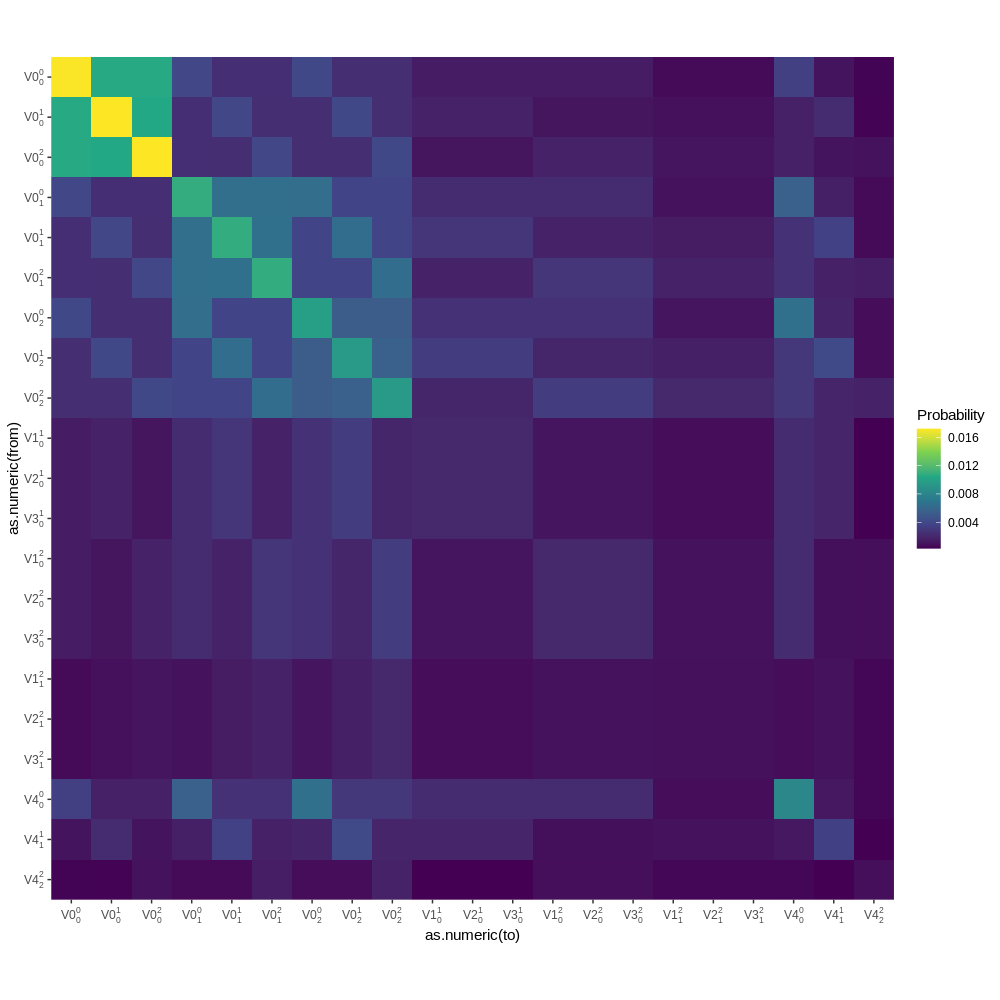

In [17]:
%%R -i tab_example -w 1000 -h 1000 -r 100

library(tidyverse)
library(latex2exp)


df <- do.call(rbind, tab_example) %>% 
    as_tibble() %>% 
    unnest() %>% 
    mutate(
        from_1 = str_sub(V1, 2, 2),
        from_2 = str_sub(V1, 5, 5),
        from_3 = str_sub(V1, 8, 8),
        to_1 = str_sub(V2, 2, 2),
        to_2 = str_sub(V2, 5, 5),
        to_3 = str_sub(V2, 8, 8)
    ) %>% 
    arrange(from_1!='0', from_1=='4', from_2, from_3, to_1!='0', to_1=='4', to_2, to_3) %>% 
    rowwise() %>% 
    transmute(
        from = paste0('$V', from_1, '_', from_2, '^', from_3, '$'),
        to = paste0('$V', to_1, '_', to_2, '^', to_3, '$'),
        value = V3
    )
    
df %>% 
    mutate(
        from = factor(from, rev(unique(df$from))),
        to = factor(to, (unique(df$from)))
    ) %>%
    ggplot() +
    geom_tile(aes(as.numeric(to), as.numeric(from), fill = value)) +
    scale_y_continuous(
        expand = c(0, 0),
        breaks = as.numeric(factor(unique(df$from), rev(unique(df$from)))),
        labels = TeX(unique(df$from))
    ) +
    scale_x_continuous(
        expand = c(0, 0),
        breaks = as.numeric(factor(unique(df$to), (unique(df$from)))),
        labels = TeX(unique(df$to))
    ) +
    scale_fill_viridis_c(name = 'Probability') +
    coord_fixed()
    

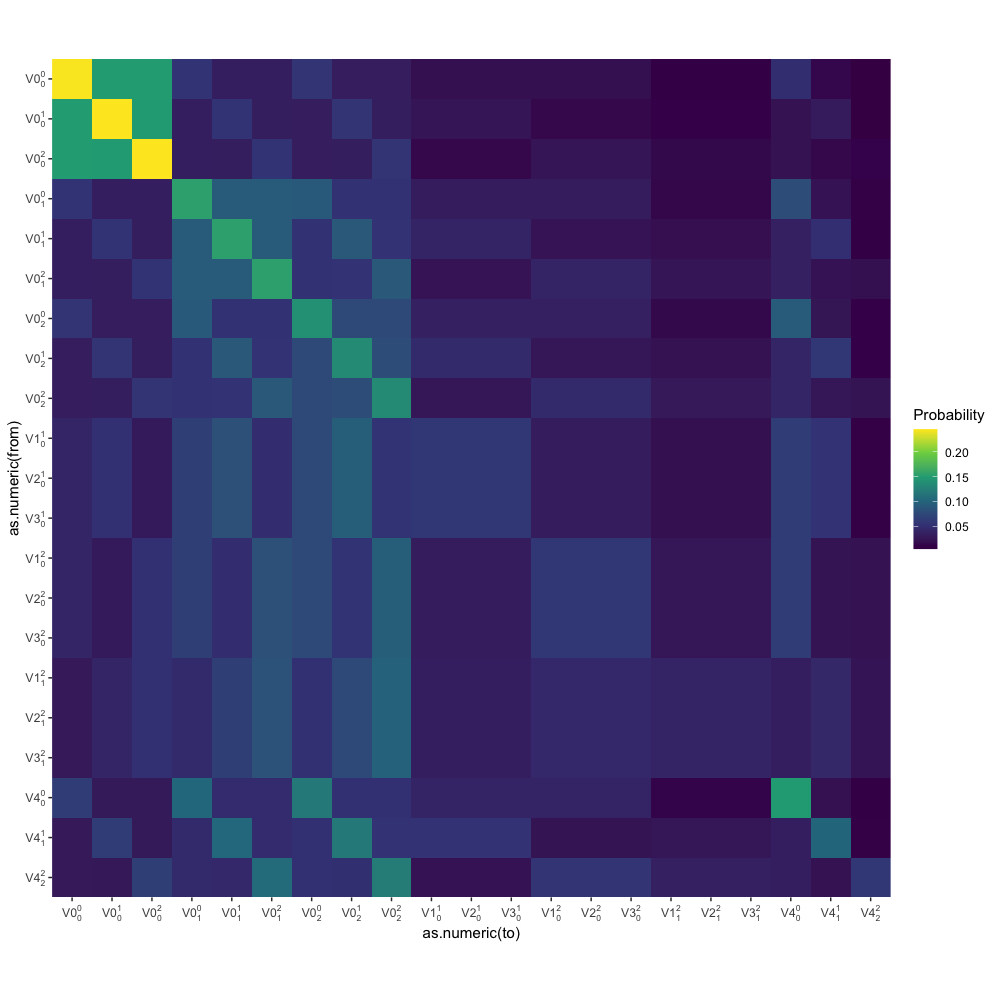

In [17]:
%%R -i tab_example -w 1000 -h 1000 -r 100

library(tidyverse)
library(latex2exp)

df <- do.call(rbind, tab_example) %>% 
    as_tibble() %>% 
    unnest() %>% 
    mutate(
        from_1 = str_sub(V1, 2, 2),
        from_2 = str_sub(V1, 5, 5),
        from_3 = str_sub(V1, 8, 8),
        to_1 = str_sub(V2, 2, 2),
        to_2 = str_sub(V2, 5, 5),
        to_3 = str_sub(V2, 8, 8)
    ) %>% 
    arrange(from_1!='0', from_1=='4', from_2, from_3, to_1!='0', to_1=='4', to_2, to_3) %>% 
    rowwise() %>% 
    transmute(
        from = paste0('$V', from_1, '_', from_2, '^', from_3, '$'),
        to = paste0('$V', to_1, '_', to_2, '^', to_3, '$'),
        value = V3
    ) %>% 
    group_by(from)  %>% 
    mutate(value = value/sum(value))
    
df %>% 
    mutate(
        from = factor(from, rev(unique(df$from))),
        to = factor(to, (unique(df$from)))
    ) %>%
    ggplot() +
    geom_tile(aes(as.numeric(to), as.numeric(from), fill = value)) +
    scale_y_continuous(
        expand = c(0, 0),
        breaks = as.numeric(factor(unique(df$from), rev(unique(df$from)))),
        labels = TeX(unique(df$from))
    ) +
    scale_x_continuous(
        expand = c(0, 0),
        breaks = as.numeric(factor(unique(df$to), (unique(df$from)))),
        labels = TeX(unique(df$to))
    ) +
    scale_fill_viridis_c(name = 'Probability')  +
    coord_fixed()

In [299]:
array_np = get_HMM_trans_mat(
    t_A = 5,    t_B = 5,    t_AB = 0.5,    t_C = 5.5, 
    rho_A = 1e-3,  rho_B = 1e-3,  rho_AB = 1e-3,  rho_C = 1e-3,  rho_ABC = 1e-8, 
    coal_A = 1, coal_B = 1, coal_AB = 1, coal_C = 1, coal_ABC = 1,
    n_int_AB = 3, n_int_ABC = 3
)

cut_HMM_AB = cutpoints_AB(3, 1, 1)
cut_HMM_ABC = 1+cutpoints_ABC(3, 1)
names_HMM = list(df_np.index)

df_np = pd.DataFrame(array_np).pivot(index = 0, columns = 1, values = 2)
pi_HMM = list(df_np.sum(axis=1))
array_np = np.array(df_np.div(pi_HMM, axis=0))

In [300]:
#np.random.seed(20)

lst = []

idx = np.random.choice(
    list(range(len(pi_HMM))), 
    p = pi_HMM
)
for i in range(1000):
        
    lst.append([
        names_HMM[idx][0], 
        cut_HMM_AB[names_HMM[idx][1]] if names_HMM[idx][0] == 0 else cut_HMM_ABC[names_HMM[idx][1]],
        cut_HMM_ABC[names_HMM[idx][2]],
        cut_HMM_AB[names_HMM[idx][1]+1] if names_HMM[idx][0] == 0 else cut_HMM_ABC[names_HMM[idx][1]+1],
        cut_HMM_ABC[names_HMM[idx][2]+1],
    ])
    idx = np.random.choice(
        list(range(len(pi_HMM))), 
        p = list(array_np[idx,:])
    )

df_HMM = pd.DataFrame(np.array(lst))

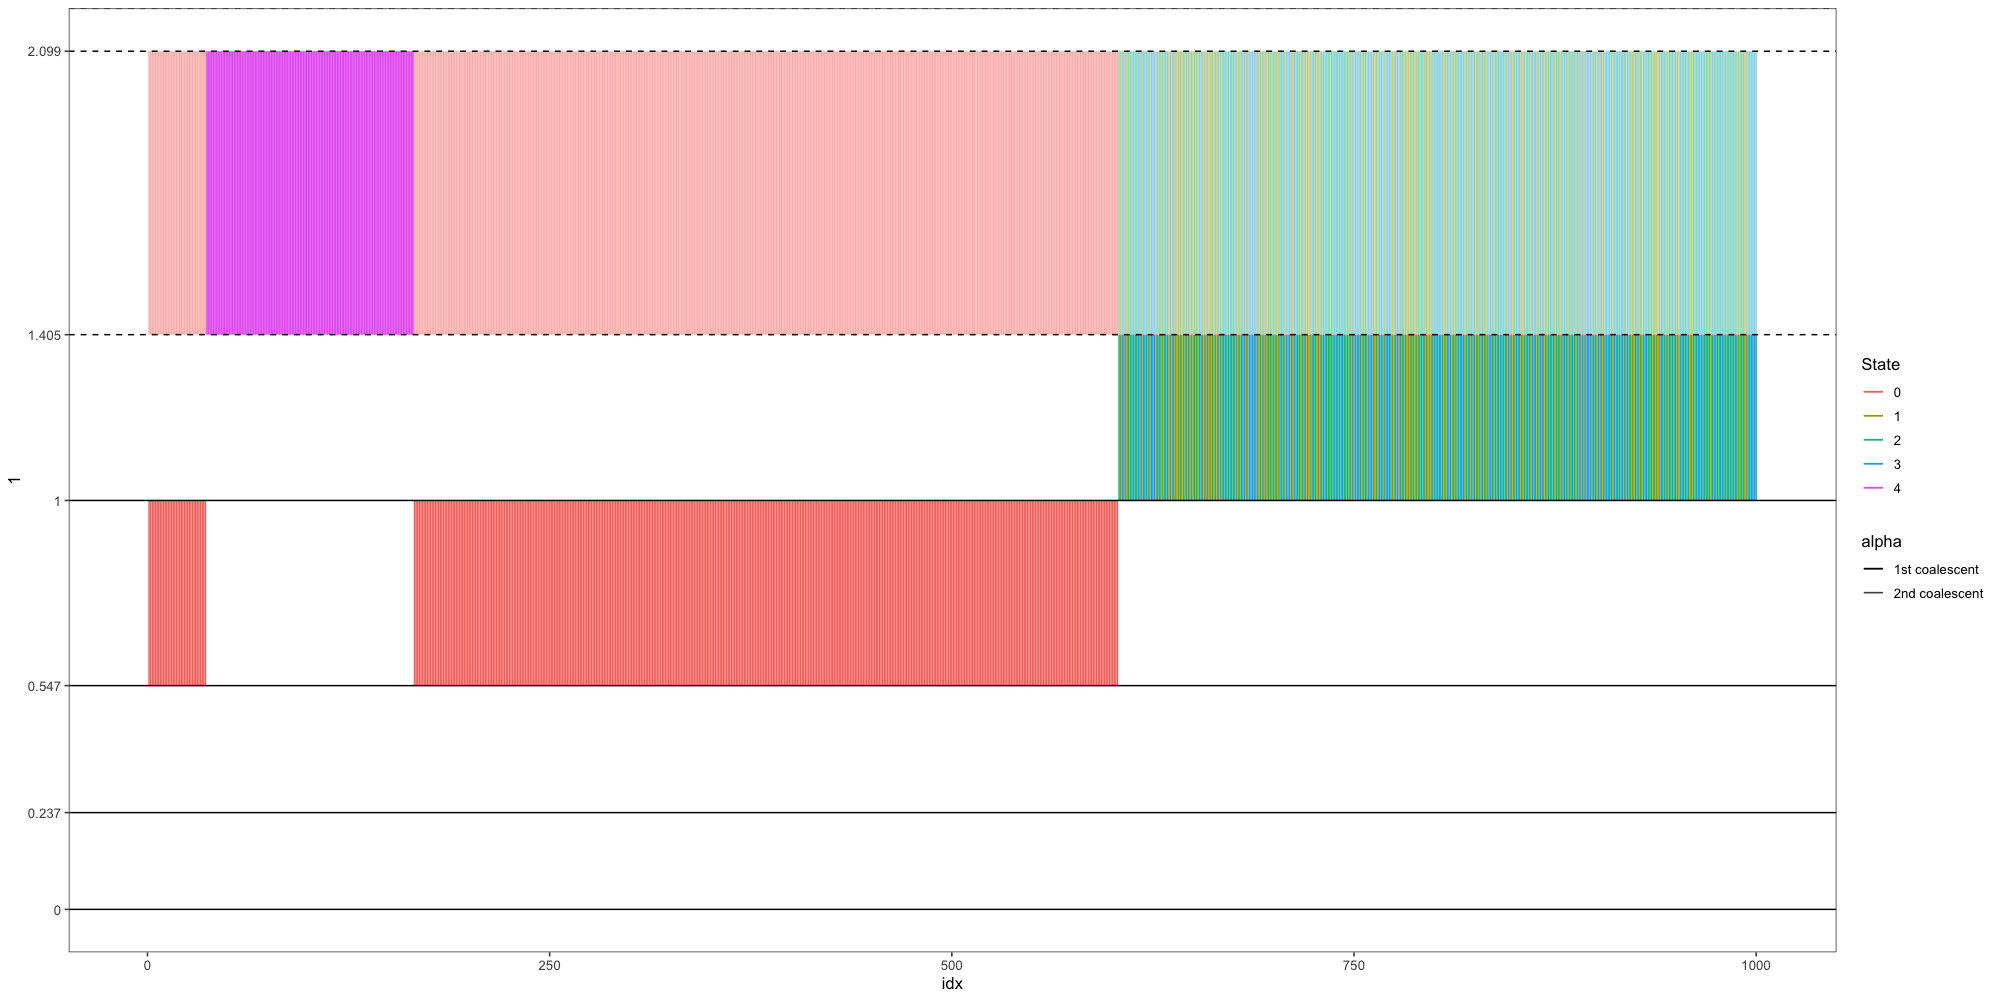

In [301]:
%%R -i df_HMM -i cut_HMM_AB -i cut_HMM_ABC -w 2000 -h 1000 -r 100

library(ggthemes)

df_HMM %>% 
    mutate(
        idx = 1:n(),
        State = as.character(`0`)
    ) %>% 
    ggplot() +
    #geom_point(aes(idx, `1`, color = as.character(`0`))) +
    #geom_point(aes(idx, `2`, color = as.character(`0`))) +
    geom_segment(aes(x = idx, xend = idx, y = `1`, yend = `3`, color = State, alpha = '1st coalescent')) +
    geom_segment(aes(x = idx, xend = idx, y = `2`, yend = `4`, color = State, alpha = '2nd coalescent')) +
    geom_hline(aes(yintercept = x), data = tibble(x = cut_HMM_AB)) +
    geom_hline(aes(yintercept = x), linetype = 2, data = tibble(x = cut_HMM_ABC[-1])) +
    theme_few() +
    scale_y_continuous(
        breaks = unique(c(cut_HMM_AB, cut_HMM_ABC)),
        labels = round(unique(c(cut_HMM_AB, cut_HMM_ABC)), 3)
    ) +
    scale_alpha_manual(values = c(1, 0.5))